# 0.0. IMPORTS

In [93]:
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import mplleaflet        as mpl
import seaborn           as sns

import random
import folium
import matplotlib

from tqdm.notebook import tqdm
%matplotlib inline

## 0.1. Help Functions

In [139]:
# Função que cria o mapa em mplleaflet
def show_traj_by_userId(df,
                        userId=None,
                        label_tid='userId',
                        label_latitude= 'latitude',
                        label_longitude= 'longitude',
                        figsize=(10,10),
                        markersize=5):
  
  fig = plt.figure(figsize=figsize)
  df_ = df[df[label_tid]==userId]
  print('shape total: {}   shape for id (): {}'.format(df.shape[0],userId,df_.shape[0]))

  ## Criando o ponto inicial e ponto final
  plt.plot(df_.iloc[0][label_longitude], df_.iloc[0][label_latitude], 'yo' , markersize=markersize+5)
  plt.plot(df_.iloc[-1][label_longitude], df_.iloc[-1][label_latitude], 'yX', markersize=markersize+5)

  plt.plot(df_[label_longitude], df_[label_latitude], 'b')
  plt.plot(df_.loc[:,label_longitude],df_.loc[:,label_latitude],'r.', markersize=markersize)
  
  return df_,fig


def haversine(lat1,lon1,lat2,lon2,to_radians=True,earth_radius=6371):
  try:
    # Convert sinfle points to array
    if to_radians:
      lat1,lon1,lat2,lon2 = np.radians([lat1,lon1,lat2,lon2])
      a = np.sin((lat2-lat1)/2.0)**2+ np.cos(lat1)*np.cos(lat2)*np.sin((lon2-lon1)/2.0)**2
    return 2 * 1000 * earth_radius * np.arctan2(a ** 0.5, (1-a) ** 0.5)
  except Exception as e:
    print('\Error Haverside fuction')
    print('lat1:{}nion1:()\nlon2:{}'.format(lat1,lon1,lat2,lon2))
    print('type(lat1) = {}\ntype(lon1)= ()\ntype(lat2) = {}\ntype(lon2)={}\n'.format(type(lat1),type(lon1),type(lat2),type(lon2)))
    raise e


def formate_tags(line, slice):
  map_formated_tags = map(lambda tag: '{}:{}'.format(tag,line(tag),slice_))
  return '<br/>'.join(map_formated_tags)


def add_traj_folium(df,
                    folium_map = None,
                    slice_tags = None,
                    tiles = 'OpenStreetMap'):
  if not slice_tags:
    slice_tags = df.columns

  if not folium_map:
    initial_lat = df['latitude'].mean()
    initial_lon = df['longitude'].mean()
    folium_map = folium.Map(location=[df['latitude'].mean(), df['longitude'].mean()],
                            control_scale=True,
                            zoom_stars=5,
                            tiles=tiles)
    
  # Criando as linhas da trajetória
  folium.PolyLine(list(zip(df['latitude'], df['longitude'])), weight=2, color='black').add_to(folium_map)    

  def circle_marker(iter_tuple,map_):
    _,line = iter_tuplex
    x = line['latitude'],
    y = line['longitude']
    tags_formated = formate_tags(line, slice_tags)

    folium.Circle(radius=1 , location=[x,y], popup=tags_formated, color='blue', fill=False).add_to(map)

    list(map(lambda x: circle_marker(x,folium_map),df.iterrows()))
  
  return folium_map   

## 0.2. Loanding data

In [95]:
%time 
filename = '/content/dataset_TSMC2014_NYC.csv'
df_raw = pd.read_csv(filename, parse_dates=['utcTimestamp'])
df_raw.head()

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.3 µs


,userId,venueId,venueCategoryId,venueCategory,latitude,longitude,timezoneOffset,utcTimestamp
0,470,49bbd6c0f964a520f4531fe3,4bf58dd8d48988d127951735,Arts & Crafts Store,40.719810,-74.002581,-240,2012-04-03 18:00:09+00:00
1,979,4a43c0aef964a520c6a61fe3,4bf58dd8d48988d1df941735,Bridge,40.606800,-74.044170,-240,2012-04-03 18:00:25+00:00
2,69,4c5cc7b485a1e21e00d35711,4bf58dd8d48988d103941735,Home (private),40.716162,-73.883070,-240,2012-04-03 18:02:24+00:00
3,395,4bc7086715a7ef3bef9878da,4bf58dd8d48988d104941735,Medical Center,40.745164,-73.982519,-240,2012-04-03 18:02:41+00:00
4,87,4cf2c5321d18a143951b5cec,4bf58dd8d48988d1cb941735,Food Truck,40.740104,-73.989658,-240,2012-04-03 18:03:00+00:00


# 1.0. DATA CLEANING 

In [96]:
df1 = df_raw.copy()

## 1.1. Selecionando 20 amostras de usuários.

In [97]:
df1['userId'].nunique()

1083

In [98]:
users = random.sample(list(df1['userId'].unique()),20)
user_to_drop = df1[df1['userId'].isin(users)==False].index
df1.drop(user_to_drop, inplace=True)

In [99]:
df1['userId'].nunique()

20

## 1.2. Ordenando os dados

In [100]:
df1.sort_values(['userId','utcTimestamp'], inplace=True)

In [101]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4801 entries, 11756 to 225874
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   userId           4801 non-null   int64              
 1   venueId          4801 non-null   object             
 2   venueCategoryId  4801 non-null   object             
 3   venueCategory    4801 non-null   object             
 4   latitude         4801 non-null   float64            
 5   longitude        4801 non-null   float64            
 6   timezoneOffset   4801 non-null   int64              
 7   utcTimestamp     4801 non-null   datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), float64(2), int64(2), object(3)
memory usage: 337.6+ KB


## 1.3. Mudando o formato dos dados

In [102]:
df1['utcTimestamp'] =    df1['utcTimestamp'].dt.tz_localize(None)
df1['userId'] =          pd.Categorical(df1['userId'])
df1['venueId'] =         pd.Categorical(df1['venueId'])
df1['venueCategoryId'] = pd.Categorical(df1['venueCategoryId'])
df1['venueCategory'] =   pd.Categorical(df1['venueCategory'])

In [103]:
df1['venueId'].nunique()

1510

In [104]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4801 entries, 11756 to 225874
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   userId           4801 non-null   category      
 1   venueId          4801 non-null   category      
 2   venueCategoryId  4801 non-null   category      
 3   venueCategory    4801 non-null   category      
 4   latitude         4801 non-null   float64       
 5   longitude        4801 non-null   float64       
 6   timezoneOffset   4801 non-null   int64         
 7   utcTimestamp     4801 non-null   datetime64[ns]
dtypes: category(4), datetime64[ns](1), float64(2), int64(1)
memory usage: 280.5 KB


## 1.4. Descriptive Statistics

In [105]:
df1.describe(include='all' , datetime_is_numeric=True)

,userId,venueId,venueCategoryId,venueCategory,latitude,longitude,timezoneOffset,utcTimestamp
count,4801.0,4801,4801,4801,4801.000000,4801.000000,4801.000000,4801
unique,20.0,1510,238,174,NaN,NaN,NaN,NaN
top,974.0,4c5cc7b485a1e21e00d35711,4bf58dd8d48988d103941735,Bar,NaN,NaN,NaN,NaN
freq,1107.0,104,356,499,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,40.745039,-73.953563,-251.422620,2012-07-12 06:25:42.734638592
min,NaN,NaN,NaN,NaN,40.573348,-74.261637,-300.000000,2012-04-03 18:02:24
25%,NaN,NaN,NaN,NaN,40.700699,-73.993939,-240.000000,2012-05-03 22:37:30
50%,NaN,NaN,NaN,NaN,40.745677,-73.967332,-240.000000,2012-06-06 09:17:06
75%,NaN,NaN,NaN,NaN,40.782083,-73.894830,-240.000000,2012-08-19 03:53:24
max,NaN,NaN,NaN,NaN,40.976245,-73.702309,-240.000000,2013-02-16 01:52:03


## 1.5. Verificando Dados Nulos

In [106]:
df1.isna().sum()

userId             0
venueId            0
venueCategoryId    0
venueCategory      0
latitude           0
longitude          0
timezoneOffset     0
utcTimestamp       0
dtype: int64

## 1.6. Verificando Dados Duplicados

In [107]:
subset = ['userId','utcTimestamp']
idx = df1.duplicated(subset=subset)
df1.loc[idx].shape[0]

6

In [108]:
## Deletando dados duplicados
df1 = df1.drop_duplicates(subset=subset)

# 2.0. FEATURE ENGENEERING

In [109]:
df2 = df1.copy()

## 2.1. dist_to_prev

In [110]:
df2['latitude'].head(2)

11756    40.750943
16797    40.781517
Name: latitude, dtype: float64

In [111]:
df2['latitude'].shift(1).head(2)

11756          NaN
16797    40.750943
Name: latitude, dtype: float64

In [112]:
prev_lat = df2['latitude'].shift(1)
prev_lon = df2['longitude'].shift(1)
df2['dist_to_prev'] = haversine(prev_lat,prev_lon, df2['latitude'],df2['longitude'])
df2.head()

,userId,venueId,venueCategoryId,venueCategory,latitude,longitude,timezoneOffset,utcTimestamp,dist_to_prev
11756,8,4afd6918f964a520a82722e3,4bf58dd8d48988d124941735,Office,40.750943,-74.006196,-240,2012-04-12 14:11:54,NaN
16797,8,4c2a4bc9b1ddc9b661e052fb,4bf58dd8d48988d130941735,Building,40.781517,-73.979738,-240,2012-04-14 23:25:21,4064.785113
17547,8,4ad854bbf964a5200b1121e3,4bf58dd8d48988d175941735,Gym / Fitness Center,40.781333,-73.979650,-240,2012-04-15 12:28:14,21.760173
29012,8,4ad854bbf964a5200b1121e3,4bf58dd8d48988d175941735,Gym / Fitness Center,40.781333,-73.979650,-240,2012-04-21 17:12:07,0.000000
30329,8,4ad854bbf964a5200b1121e3,4bf58dd8d48988d175941735,Gym / Fitness Center,40.781333,-73.979650,-240,2012-04-22 12:16:34,0.000000


In [113]:
df2.set_index('userId',inplace=True)
users = df2.index

In [114]:
for u in tqdm(users):
  curr_lat = df2.at[u,'latitude']
  curr_lon = df2.at[u,'longitude']

  size_id = curr_lat.size

  if size_id <= 1:
    print('...id:(), must have at least 2 GPS points\n'.format(idx))
    df2.at[u, 'dist_to_prev'] = np.nan

  else :
    prev_lat = curr_lat.shift(1)
    prev_lon = curr_lon.shift(1)

    df2.at[u, 'dist_to_prev'] = haversine(prev_lat, prev_lon, curr_lat, curr_lon)

  0%|          | 0/4795 [00:00<?, ?it/s]

In [115]:
df2.at[u,'dist_to_prev'] = haversine(prev_lat,prev_lon,curr_lat,curr_lon)

## 2.2. time_to_prev

In [116]:
df2['time_to_prev']=-1.0

for u in tqdm(users):
  curr_lat = list(df2.at[u,'latitude'])[0]
  curr_lon = list(df2.at[u,'longitude'])[0]

  size_id = curr_lat
  

  if size_id <= 1:
    print('...id:(), must have at least 2 GPS points\n'.format(idx))
    df2.at[u,'time_to_prev']=np.nan
  else:
    time_curr = pd.Series(df2.at[u,'utcTimestamp'])
    time_prev = (time_curr - time_curr.shift(1))
    df2.at[u,'time_to_prev']= time_prev

  0%|          | 0/4795 [00:00<?, ?it/s]

In [117]:
df2['time_to_prev'].head()

userId
8                NaT
8    2 days 09:13:27
8    0 days 13:02:53
8    6 days 04:43:53
8    0 days 19:04:27
Name: time_to_prev, dtype: object

## 2.3. time_to_prev e speed_to_prev

In [118]:
df2['time_to_prev'] = pd.to_timedelta(df2['time_to_prev']).dt.total_seconds()
df2['speed_to_prev'] = df2['dist_to_prev']/df2['time_to_prev']
df2.describe(percentiles=[0.90,0.95,0.99])

,latitude,longitude,timezoneOffset,dist_to_prev,time_to_prev,speed_to_prev
count,4795.000000,4795.000000,4795.000000,4775.000000,4.775000e+03,4775.000000
mean,40.745015,-73.953601,-251.436913,4061.654803,8.899712e+04,6.241642
std,0.069633,0.092990,23.569635,5414.254255,2.943027e+05,33.713121
min,40.573348,-74.261637,-300.000000,0.000000,1.000000e+00,0.000000
50%,40.745649,-73.967332,-240.000000,1640.889914,1.368500e+04,0.173405
90%,40.848395,-73.811592,-240.000000,11465.035995,1.902090e+05,10.576787
95%,40.861493,-73.806603,-240.000000,16925.560806,3.837526e+05,23.974585
99%,40.874292,-73.789090,-240.000000,22803.220633,1.196801e+06,134.399508
max,40.976245,-73.702309,-240.000000,34252.008299,7.741761e+06,1317.484051


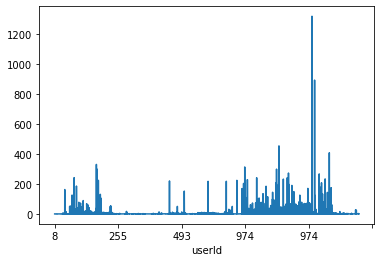

In [119]:
df2['speed_to_prev'].plot()

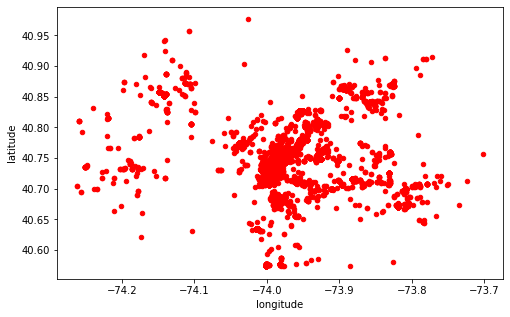

In [120]:
fig, ax = plt.subplots(figsize=(8,5))
df2.plot('longitude','latitude',kind='scatter', color='r', ax=ax)

In [121]:
df2 = df2[df2['speed_to_prev'].isna()==False]

In [122]:
user_to_drop = df2[df2['speed_to_prev']>20].index
df2.drop(user_to_drop, inplace=True)
print('{} pontos foram removidos.'.format(len(user_to_drop)))

289 pontos foram removidos.


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


# 3.0. DATA VISUALIZATION

In [124]:
df3 = df2.copy()

## 3.1. Visualizando o mapa da trajetória.

In [135]:
userId = list(df3['userId'])[0]
df_aux,fig = show_traj_by_userId(df3,userId=userId)
mpl.display(fig, tiles='cartodb_positron')

shape total: 1478   shape for id (): 8


/usr/local/lib/python3.8/dist-packages/IPython/core/display.py:701: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


## 3.2. Visualizando dados com o Folium

In [137]:
base_map = folium.Map(location=[df3['latitude'].mean(), df3['longitude'].mean()],
                      control_scale=True,
                      zoom_start=5)
base_map

In [144]:
users = df3['userId'].value_counts()
map = add_traj_folium(df3[df3['userId']==users.index[0]], tiles='cartodbpositron')
map